In [ ]:
# conda env: datacat (Python 3.8.20)
"""
Prepare FS-MOl like datasets for use with CL Models.
example call:
python datacat4ml/Scripts/data_split/prep_fsmol_alike.py
"""
import sys
import os

import random

from enum import Enum
from typing import List, Optional, Dict, Union
import logging
logger = logging.getLogger(__name__)
import json
import numpy as np
import pandas as pd
from collections import defaultdict
import tqdm
from pathlib import Path
import missingno as msno

from datacat4ml.Scripts.const import SPL_DATA_DIR
from datacat4ml.Scripts.const import CURA_MHD_GPCR_DIR, FEAT_MHD_OR_DIR, CURA_MHD_OR_DIR
from datacat4ml.Scripts.const import RANDOM_SEED, OR_chemblids

# 'datafold_actid.json' preparation

In [3]:
def get_actids(gpcr_dir, or_dir):

    # Prepare GPCR dataset
    gpcr_ds = [] # without ORs
    gpcr_actids = []
    for f in os.listdir(gpcr_dir):
        if not any(f.startswith(x) for x in OR_chemblids):
            gpcr_ds.append(f)

            df = pd.read_csv(os.path.join(gpcr_dir, f))
            actids = df['activity_id'].tolist()
            gpcr_actids.extend(actids)

    print(f'len gpcr_ds: {len(gpcr_ds)}')
    print(f'len gpcr_actids: {len(gpcr_actids)}')
    print(f'len set gpcr_actids: {len(set(gpcr_actids))}') # check for duplicates

    # Prepare OR dataset
    or_ds = [] # only ORs
    or_actids = []
    for f in os.listdir(or_dir):
        or_ds.append(f)

        #df = pd.read_pickle(os.path.join(or_dir, f))
        df= pd.read_csv(os.path.join(or_dir, f))
        actids = df['activity_id'].tolist()
        or_actids.extend(actids)

    print(f'len or_ds: {len(or_ds)}')
    print(f'len or_actids: {len(or_actids)}')
    print(f'len set or_actids: {len(set(or_actids))}')

    return gpcr_actids, or_actids

gpcr_dir = os.path.join(CURA_MHD_GPCR_DIR, 'rmvD0')
#or_dir = os.path.join(FEAT_MHD_OR_DIR, 'rmvD0')
or_dir = os.path.join(CURA_MHD_OR_DIR, 'rmvD0')

gpcr_actids, or_actids = get_actids(gpcr_dir, or_dir)

len gpcr_ds: 948
len gpcr_actids: 233222
len set gpcr_actids: 233222
len or_ds: 39
len or_actids: 23244
len set or_actids: 23244


In [4]:
def prep_datafold_actid(gpcr_actids, or_actids, 
                        random_seed=RANDOM_SEED, tr_val_ratio=100, out_dir=None):

    """
    Prepare DataFold dict with train/valid/test splits based on activity_ids.
    """
    datafold = defaultdict(list)
    for actid in or_actids:
        datafold['test'].append(actid)
    for actid in gpcr_actids:
        datafold['train'].append(actid)

    # Shuffle for randomness
    random.seed(random_seed)
    random.shuffle(datafold['train'])

    # calculate validation set size
    n_train = len(datafold['train'])
    n_valid = max(1, n_train // (tr_val_ratio + 1)) # 100:1 split

    # split into train/valid
    datafold['valid'] = datafold['train'][:n_valid]
    datafold['train'] = datafold['train'][n_valid:]

    if out_dir is not None:
        os.makedirs(out_dir, exist_ok=True)
        with open(os.path.join(out_dir, 'datafold_actid.json'), 'w') as f:
            json.dump(datafold, f, indent=2)

    print(f'len(datafold): {len(datafold)}')
    print(f'len(datafold["train"]): {len(datafold["train"])}; \nlen(datafold["valid"]): {len(datafold["valid"])}; \nlen(datafold["test"]): {len(datafold["test"])}')

    return datafold

ratio = 100
out_dir = os.path.join(SPL_DATA_DIR, 'cl')

datafold_actid = prep_datafold_actid(gpcr_actids, or_actids, RANDOM_SEED, ratio, out_dir)

len(datafold): 3
len(datafold["train"]): 230913; 
len(datafold["valid"]): 2309; 
len(datafold["test"]): 23244


# 'datafold_ds.json' preparation

In [14]:
def get_ds(gpcr_dir, or_dir):
    """
    Get GPCR and OR datasets from the specified directories.

    params
    ----------
    gpcr_dir: str, 
        Path to the directory containing GPCR MHD files. Default: CURA_MHD_GPCR_DIR/rmvD0
    or_dir: str, 
        Path to the directory containing OR MHD files. Default: FEAT_MHD_OR_DIR/rmvD0

    returns
    -------
    gpcr_ds: List[str],
        List of GPCR dataset filenames (excluding ORs).
    or_ds: List[str],
        List of OR dataset filenames (only ORs).
    
    """
    # Prepare GPCR dataset
    gpcr_ds = [] # without ORs
    for f in os.listdir(gpcr_dir):
        if not any(f.startswith(x) for x in OR_chemblids):
            gpcr_ds.append(f)
    print(f'len gpcr_ds: {len(gpcr_ds)}')

    # Prepare OR dataset
    or_ds = [] # only ORs
    for f in os.listdir(or_dir):
        or_ds.append(f)
    len(or_ds)
    print(f'len or_ds: {len(or_ds)}')

    return gpcr_ds, or_ds

gpcr_ds, or_ds = get_ds(gpcr_dir, or_dir)

len gpcr_ds: 948
len or_ds: 39


In [15]:
def prep_datafold_ds(gpcr_ds, or_ds, 
                     random_seed=RANDOM_SEED, tr_val_ratio=100, out_dir=None):
    """
    
    params:
    ----------
    tr_val_ratio: int,
        Ratio for train/valid split. Default: 100 (i.e., 100:1 split)
    out_dir: str,
        Path to the output directory where MHDsFold.json will be saved. Default: SPL_DATA_DIR/cl

    returns:
    ----------
    datafold_ds: dict,
        A dictionary containing the train, valid, and test splits.
    """
    # gpcr_ds -> train/valid, or_ds -> test
    datafold = defaultdict(list)
    for ds in or_ds:
        datafold['test'].append(ds)
    for ds in gpcr_ds:
        datafold['train'].append(ds)

    # Shuffle for randomness
    random.seed(random_seed)
    random.shuffle(datafold['train'])

    # calculate validation set size
    n_train = len(datafold['train'])
    n_valid = max(1, n_train // (tr_val_ratio + 1))  # 100:1 split

    # split into train/valid
    datafold['valid'] = datafold['train'][:n_valid]
    datafold['train'] = datafold['train'][n_valid:]

    if out_dir is not None:
        os.makedirs(out_dir, exist_ok=True)
        with open(os.path.join(out_dir, 'datafold_ds.json'), 'w') as f:
            json.dump(datafold, f, indent=2)

    print(f'len(datafold): {len(datafold)}')
    print(f'len(datafold["train"]): {len(datafold["train"])}; \nlen(datafold["valid"]): {len(datafold["valid"])}; \nlen(datafold["test"]): {len(datafold["test"])}')

    return datafold

ratio = 100
out_dir = os.path.join(SPL_DATA_DIR, 'cl')

datafold_ds = prep_datafold_ds(gpcr_ds, or_ds, RANDOM_SEED, ratio, out_dir)

len(datafold): 3
len(datafold["train"]): 939; 
len(datafold["valid"]): 9; 
len(datafold["test"]): 39


# DataFold

In [24]:
class DataFold(Enum):
    TRAIN = 0
    VALIDATION = 1
    TEST =2

def prep_cl_split(gpcr_dir, or_dir, datafold_actid, datafold_ds):
    """

    """
    #===================== fold_type: 'ds' =====================#
    train_files = datafold_ds['train']
    valid_files = datafold_ds['valid']
    test_files = datafold_ds['test']

    # train/valid data from gpcr_dir
    train_ds = [os.path.join(gpcr_dir, f) for f in train_files]
    valid_ds = [os.path.join(gpcr_dir, f) for f in valid_files]
    test_ds = [os.path.join(or_dir, f) for f in test_files]

    train_ds_df = pd.concat([pd.read_csv(f, index_col=0) for f in train_ds], ignore_index=True)
    valid_ds_df = pd.concat([pd.read_csv(f, index_col=0) for f in valid_ds], ignore_index=True)
    test_ds_df = pd.concat([pd.read_csv(f, index_col=0) for f in test_ds], ignore_index=True)
    
    splits_ds_dfs = {
        'train': train_ds_df,
        'valid': valid_ds_df,
        'test': test_ds_df
    }
    for split, df in splits_ds_dfs.items():
        print(f'{split} df shape: {df.shape}')

    #===================== fold type: 'actid' =====================#
    all_dfs = pd.concat([train_ds_df, valid_ds_df, test_ds_df], ignore_index=True)
    print(f'all_dfs shape: {all_dfs.shape}')
    print(f'all_dfs columns: {all_dfs.columns.tolist()}')

    train_actid = datafold_actid['train']
    valid_actid = datafold_actid['valid']
    test_actid = datafold_actid['test']

    train_actid_df = all_dfs[all_dfs['activity_id'].isin(train_actid)]
    valid_actid_df = all_dfs[all_dfs['activity_id'].isin(valid_actid)]
    test_actid_df = all_dfs[all_dfs['activity_id'].isin(test_actid)]

    splits_actid_dfs = {
        'train': train_actid_df,
        'valid': valid_actid_df,
        'test': test_actid_df
    }
    for split, df in splits_actid_dfs.items():
        print(f'{split} df shape (actid): {df.shape}')

    return splits_ds_dfs, splits_actid_dfs

print(f'gpcr_dir: {gpcr_dir}')
split_ds_dfs, split_actid_dfs = prep_cl_split(gpcr_dir, or_dir, datafold_actid, datafold_ds)

gpcr_dir: /storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/data_prep/data_curate/cura_mhd_gpcr/rmvD0
train df shape: (232096, 49)
valid df shape: (1126, 49)
test df shape: (23244, 49)
all_dfs shape: (256466, 49)
all_dfs columns: ['assay_id', 'assay_chembl_id', 'tid', 'target_chembl_id', 'standard_type', 'standard_relation', 'standard_value', 'standard_units', 'pchembl_value', 'assay_type', 'assay_type_description', 'assay_category', 'assay_organism', 'assay_tax_id', 'assay_strain', 'assay_tissue', 'assay_cell_type', 'assay_subcellular_fraction', 'bao_format', 'bao_label', 'variant_id', 'assay_test_type', 'assay_description', 'cell_id', 'tissue_id', 'curated_by', 'aidx', 'confidence_score', 'confidence_score_description', 'molregno', 'compound_chembl_id', 'pref_name', 'canonical_smiles', 'assay_metadata_hash', 'canonical_smiles_by_Std', 'molecular_weight', 'num_atoms', 'pStandard_value', 'vs_activity_comment', 'vs_activity', 'vs_threshold', 'lo_activity_comment', 'lo_activity', 'lo_t

KeyError: 'activity_id'

In [ ]:
def prep_parquet_old(split_dfs: dict, output_dir):
    """
    Preprocess the datasets (train/valid/test) into CLIP-compatible format.

    Args:
        split_dfs (dict): Dictionary with keys 'train', 'valid', 'test' and values as corresponding pandas DataFrames.
        output_dir (str or Path): Directory to write the processed .parquet files.
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    tasks_dic = defaultdict(list)
    activity_triplet = []
    assay_info_dict = {} 
    compound2index = {}
    activity2index = {}

    print('Preprocessing datasets: train, valid, test')

    for split_name, df in split_dfs.items():
        print(f"Processing split: {split_name}")
        for _, row in df.iterrows():
            # for compound2index, activity2index and activity triplet
            assay_id = row['assay_id']
            compound_smiles = row['canonical_smiles_by_Std']
            label = row['activity']                  # binary: 0 or 1
            label_numeric = row['pStandard_value']   # regression label

            assay_chembl_id = row['assay_chembl_id']
            assay_type = row['assay_type']
            assay_type_desc = row['assay_type_desc']
            assay_category = row['assay_category']
            assay_organism = row['assay_organism']
            assay_tax_id = row['assay_tax_id']
            assay_strain = row['assay_strain']
            assay_tissue = row['assay_tissue']
            assay_cell_type = row['assay_cell_type']
            assay_subcellular_fraction = row['assay_subcellular_fraction']
            bao_format = row['bao_format']
            bao_label = row['bao_label']
            variant_id = row['variant_id']
            assay_test_type = row['assay_test_type']
            assay_desc = row['assay_desc']

            cell_id = row['cell_id']
            tissue_id = row['tissue_id']
            relationship_type = row['relationship_type']
            relationship_type_desc = row['relationship_type_desc']
            aidx = row['aidx']
            confidence_score = row['confidence_score']
            confidence_score_desc = row['confidence_score_desc']
            tid = row['tid']

            target_chembl_id = row['target_chembl_id']
            effect = row['effect']
            effect_desc = row['effect_desc']
            assay = row['assay']
            assay_kw_desc = row['assay_kw_desc']
            std_type = row['std_type']

            standard_relation = row['standard_relation']
   
            # Compound index
            cid_index = compound2index.get(compound_smiles, len(compound2index))
            compound2index[compound_smiles] = cid_index

            # Activity index
            aid_index = activity2index.get(assay_id, len(activity2index))
            activity2index[assay_id] = aid_index

            # Save task name per split
            tasks_dic[split_name].append(assay_id)

            # Append activity triplet
            activity_triplet.append({
                'compound_idx': cid_index,
                'assay_idx': aid_index,
                'activity': int(label),
                'activity_numeric': label_numeric,
                'split': split_name,
            })

            # append assay info
            # Save assay info only once per assay_id
            if assay_id not in assay_info_dict:
                assay_info_dict[assay_id] = {
                    'assay_idx': aid_index,

                    'assay_id': assay_id,
                    'assay_chembl_id': assay_chembl_id,
                    'assay_description': assay_desc,

                    'assay_type': assay_type,
                    'assay_type_description': assay_type_desc,
                    'assay_category': assay_category,
                    'assay_organism': assay_organism,
                    'assay_tax_id': assay_tax_id,
                    'assay_strain': assay_strain,
                    'assay_tissue': assay_tissue,
                    'assay_cell_type': assay_cell_type,
                    'assay_subcellular_fraction': assay_subcellular_fraction,
                    'bao_format': bao_format,
                    'bao_label': bao_label,
                    'variant_id': variant_id,
                    'assay_test_type': assay_test_type,

                    'cell_id': cell_id,
                    'tissue_id': tissue_id,
                    'relationship_type': relationship_type,
                    'relationship_type_description': relationship_type_desc,
                    'aidx': aidx,
                    'confidence_score': confidence_score,
                    'confidence_score_description': confidence_score_desc,

                    'tid': tid,
                    'target_chembl_id': target_chembl_id,
                    'effect': effect,
                    'effect_description': effect_desc,
                    'assay': assay,
                    'assay_keywords_description': assay_kw_desc,
                }

    # Save activity triplet
    activity_triplet_df = pd.DataFrame(activity_triplet)
    activity_triplet_df.to_parquet(output_dir / 'activity.parquet')

    # Save assay info without duplicates
    assay_info_df = pd.DataFrame(list(assay_info_dict.values()))
    assay_info_df.to_parquet(output_dir / 'assay_info.parquet')

    #assay_info_df = pd.DataFrame(assay_info)
    #assay_info_df.to_parquet(output_dir / 'assay_info.parquet')

    # Save compound smiles
    compound_smiles_df =pd.DataFrame({
        'CID': list(compound2index.values()),
        'CanonicalSMILES': list(compound2index.keys())
    })
    compound_smiles_df.to_parquet(output_dir / 'compound_smiles.parquet')


    # save compound index
    compound_names_df = pd.DataFrame({
        'CID': list(compound2index.values()), 
    })
    compound_names_df.to_parquet(output_dir / 'compound_names.parquet')

    logger.info(f'Finished preprocessing. Files saved to: {output_dir}')

    return activity_triplet_df, assay_info_df, compound_smiles_df, compound_names_df

In [ ]:
activity_triplet_df, assay_info_df, compound_smiles_df, compound_names_df = prep_parquet(split_dfs, output_dir=os.path.join(split_dir, 'fsmol_alike', 'MHDsFold'))

# Visualize the `parquet` files

## `activity.parquet`

In [ ]:
print(f"{activity_triplet_df['split'].value_counts()}\n")
print(f"The number of unique compounds in the dataset is: {activity_triplet_df['compound_idx'].nunique()} \n")
print(f"The number of unique assays in the dataset is: {activity_triplet_df['assay_idx'].nunique()} \n")
print(f"The active/inactive ratio is {sum(activity_triplet_df['activity']) / len(activity_triplet_df['activity'])} \n")
activity_triplet_df

split
train    189667
test      20377
valid      1462
Name: count, dtype: int64

The number of unique compounds in the dataset is: 118736 

The number of unique assays in the dataset is: 18292 

The active/inactive ratio is 0.8490066475655537 



,compound_idx,assay_idx,activity,activity_numeric,split
0,0,0,1,6.779892,train
1,1,1,1,5.742321,train
2,2,1,1,5.832683,train
3,3,1,0,5.000000,train
4,4,1,0,5.000000,train
...,...,...,...,...,...
211501,118424,18288,1,8.113509,test
211502,118425,18288,1,7.050610,test
211503,118734,18289,0,4.522879,test
211504,118428,18290,0,5.000000,test


## `compound_smiles.parquet` & `compound_names.parquet`

In [ ]:
compound_smiles_df

,CID,CanonicalSMILES
0,0,CNC1CCN(c2ccc(NC(=O)c3ccc(-c4ccccc4)cc3)cc2)C1
1,1,O=C(CNCc1ccc(Oc2ccccc2)cc1)Nc1ccc2ncn(CCN3CCCC...
2,2,O=C(Cc1ccc(OCc2ccccc2)cc1)Nc1ccc2ccn(CCN3CCCC3...
3,3,O=C(Cc1ccc(OCc2ccccc2)cc1)Nc1ccc2ncn(CCN3CCCC3...
4,4,O=C(Cc1ccc(OCc2ccccc2)cc1)Nc1ccc2c(c1)ncn2CCN1...
...,...,...
118731,118731,CC(C)CN(C(=O)c1cccc(Cl)c1Cl)[C@H]1CCNC1
118732,118732,CCCCCC=Cc1c(O)cc(C=CC(C)C)c2c1CC(O)O2
118733,118733,Nc1ccnc(-c2cc(-c3ccon3)n(Cc3ccccc3F)n2)n1
118734,118734,CC(C)C[C@@H](N)C(=O)Nc1ccc(-c2cnco2)c(OC(F)F)c1


## `assay_info.parquet` 

In [ ]:
# General info
print(f'The number of unique assays in the dataset is {assay_info_df["assay_idx"].nunique()} \n')
print(f'The number of unique target is {assay_info_df["target_chembl_id"].nunique()} \n')
#print(f"{assay_info_df['split'].value_counts()}\n")
print(f"{assay_info_df['confidence_score'].value_counts()}\n")
print(f"{assay_info_df['effect'].value_counts()}\n")
print(f"{assay_info_df['assay'].value_counts()}\n")
#print(f"{assay_info_df['std_type'].value_counts()}\n")
print(f'The columns in the assay_info_df are: {assay_info_df.columns} \n')
assay_info_df

The number of unique assays in the dataset is 18292 

The number of unique target is 203 

confidence_score
9    13907
8     4385
Name: count, dtype: int64

effect
bind     14225
agon      2852
antag     1215
Name: count, dtype: int64

assay
RBA         14225
G_Ca         1406
G_cAMP       1202
G_GTP        1168
B_arrest      291
Name: count, dtype: int64

The columns in the assay_info_df are: Index(['assay_idx', 'assay_id', 'assay_chembl_id', 'assay_description',
       'assay_type', 'assay_type_description', 'assay_category',
       'assay_organism', 'assay_tax_id', 'assay_strain', 'assay_tissue',
       'assay_cell_type', 'assay_subcellular_fraction', 'bao_format',
       'bao_label', 'variant_id', 'assay_test_type', 'cell_id', 'tissue_id',
       'relationship_type', 'relationship_type_description', 'aidx',
       'confidence_score', 'confidence_score_description', 'tid',
       'target_chembl_id', 'effect', 'effect_description', 'assay',
       'assay_keywords_description'],
     

,assay_idx,assay_id,assay_chembl_id,assay_description,assay_type,assay_type_description,assay_category,assay_organism,assay_tax_id,assay_strain,...,relationship_type_description,aidx,confidence_score,confidence_score_description,tid,target_chembl_id,effect,effect_description,assay,assay_keywords_description
0,0,305366,CHEMBL832882,Inhibitory concentration against human MCH-R1-...,B,Binding,NaN,Homo sapiens,9606.0,NaN,...,Direct protein target assigned,CLD0,9,Direct single protein target assigned,19905,CHEMBL344,antag,antagonism,G_Ca,G-protein dependent functional assays: IP3/IP1...
1,1,312487,CHEMBL832411,Inhibition of melanin concentrating hormone re...,F,Functional,NaN,Homo sapiens,9606.0,NaN,...,Direct protein target assigned,CLD0,9,Direct single protein target assigned,19905,CHEMBL344,antag,antagonism,G_Ca,G-protein dependent functional assays: IP3/IP1...
2,2,305305,CHEMBL832852,Tested for MCH-1 induced [Ca2+] release from C...,B,Binding,NaN,Homo sapiens,9606.0,NaN,...,Direct protein target assigned,CLD0,9,Direct single protein target assigned,19905,CHEMBL344,antag,antagonism,G_Ca,G-protein dependent functional assays: IP3/IP1...
3,3,313042,CHEMBL835733,Concentration required to inhibit 50% of melan...,F,Functional,NaN,Homo sapiens,9606.0,NaN,...,Direct protein target assigned,CLD0,9,Direct single protein target assigned,19905,CHEMBL344,antag,antagonism,G_Ca,G-protein dependent functional assays: IP3/IP1...
4,4,313043,CHEMBL835734,Concentration required to inhibit 50% of melan...,F,Functional,NaN,Homo sapiens,9606.0,NaN,...,Direct protein target assigned,CLD0,9,Direct single protein target assigned,19905,CHEMBL344,antag,antagonism,G_Ca,G-protein dependent functional assays: IP3/IP1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18287,18287,2169950,CHEMBL5055009,"Displacement of [3H]U69,593 from human kappa o...",B,Binding,NaN,Homo sapiens,9606.0,NaN,...,Direct protein target assigned,1348660,9,Direct single protein target assigned,137,CHEMBL237,bind,binding affinity,RBA,Receptor binding assay: radioligand binding assay
18288,18288,146100,CHEMBL753328,Inhibitory activity against Opioid receptor ka...,B,Binding,NaN,Bos taurus,9913.0,NaN,...,Homologous protein target assigned,CLD0,8,Homologous single protein target assigned,137,CHEMBL237,bind,binding affinity,RBA,Receptor binding assay: radioligand binding assay
18289,18289,2120027,CHEMBL4829174,Inhibition of kappa opioid receptor (unknown o...,B,Binding,NaN,Homo sapiens,9606.0,NaN,...,Direct protein target assigned,1339005,9,Direct single protein target assigned,137,CHEMBL237,bind,binding affinity,RBA,Receptor binding assay: radioligand binding assay
18290,18290,2173483,CHEMBL5058731,OPRK1 Eurofins SafetyScan (Receptor),B,Binding,NaN,Homo sapiens,9606.0,NaN,...,Direct protein target assigned,TP_050_SafetyScan_OPRK1_antago,9,Direct single protein target assigned,137,CHEMBL237,bind,binding affinity,RBA,Receptor binding assay: radioligand binding assay


In [ ]:
# the fraction of missing values per column
sparsity = assay_info_df.isna().mean().sort_values(ascending=False)
print(sparsity)

variant_id                       1.000000
assay_strain                     1.000000
assay_category                   0.998469
tissue_id                        0.988684
assay_tissue                     0.988410
assay_subcellular_fraction       0.978351
assay_test_type                  0.957522
cell_id                          0.531653
assay_cell_type                  0.430735
assay_tax_id                     0.216488
assay_organism                   0.207632
target_chembl_id                 0.000000
effect                           0.000000
effect_description               0.000000
relationship_type_description    0.000000
tid                              0.000000
confidence_score_description     0.000000
confidence_score                 0.000000
assay                            0.000000
aidx                             0.000000
assay_idx                        0.000000
relationship_type                0.000000
assay_id                         0.000000
bao_label                        0

In [ ]:
# the sparse columns
print(f"{assay_info_df['assay_category'].value_counts()}\n")
print(f"{assay_info_df['tissue_id'].value_counts()}\n")
print(f"{assay_info_df['assay_tissue'].value_counts()}\n")
print(f"{assay_info_df['assay_subcellular_fraction'].value_counts()}\n")
print(f"{assay_info_df['assay_test_type'].value_counts()}\n")
print(f"{assay_info_df['cell_id'].value_counts()}\n")
print(f"{assay_info_df['assay_cell_type'].value_counts()}\n")
print(f"{assay_info_df['assay_tax_id'].value_counts()}\n")
print(f"{assay_info_df['assay_organism'].value_counts()}\n")

assay_category
Affinity biochemical assay            12
Selectivity assay                     10
Affinity phenotypic cellular assay     3
Affinity on-target cellular assay      3
Name: count, dtype: int64

tissue_id
955.0         75
2435.0        22
2107.0        15
956.0         11
1969.0        10
2106.0         9
10000000.0     7
945.0          7
5383.0         5
966.0          5
2113.0         5
2048.0         4
2037.0         4
178.0          4
995.0          4
1199.0         4
947.0          3
2116.0         2
1851.0         2
1870.0         2
1886.0         1
948.0          1
369.0          1
7.0            1
18303.0        1
1831.0         1
451.0          1
Name: count, dtype: int64

assay_tissue
Brain                76
Striatum             22
Liver                15
Cerebral cortex      12
Plasma               10
Spleen                9
Hippocampus           7
Stomach               7
Kidney                5
Caudate-putamen       5
Retina                5
Lung                 

<Axes: >

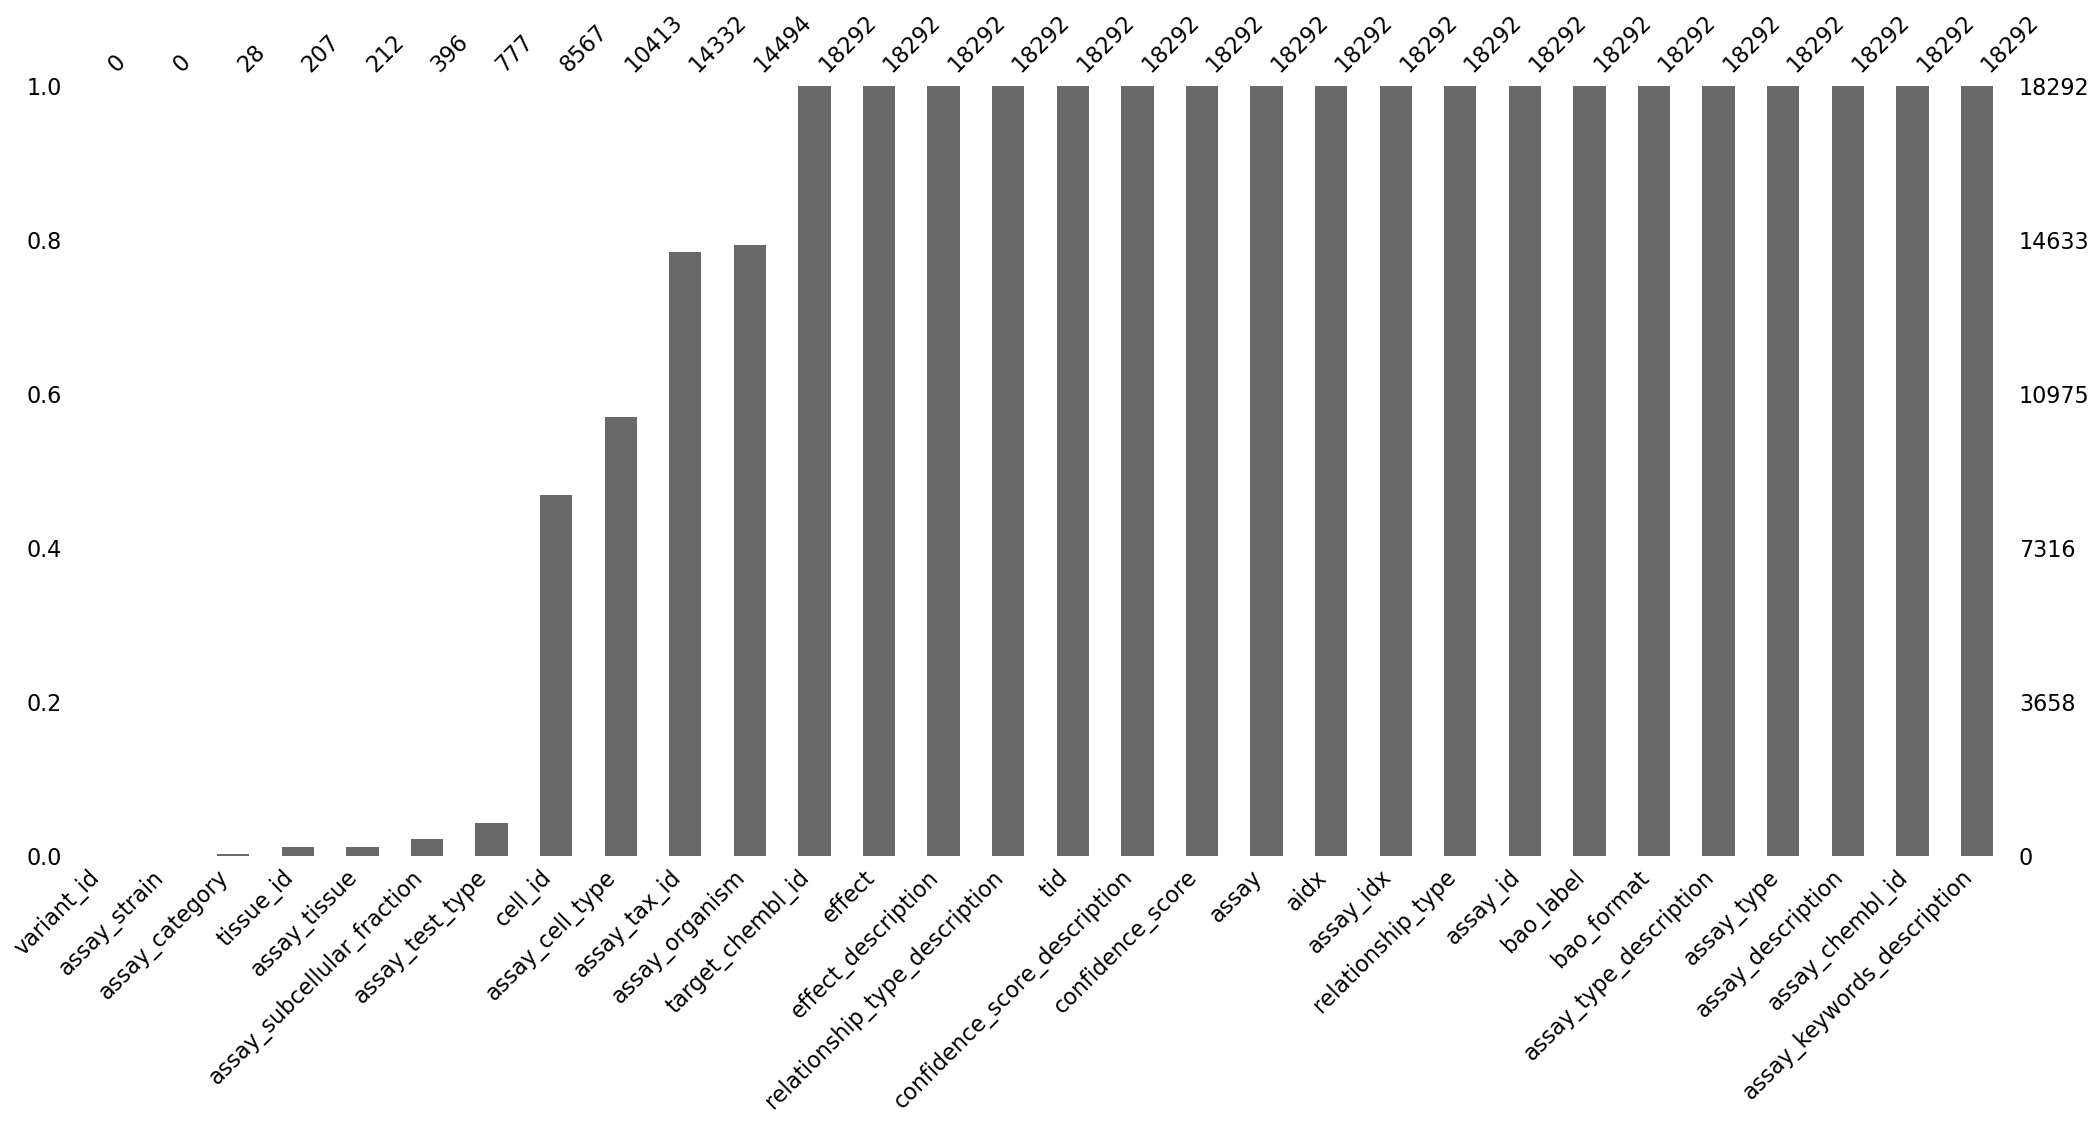

In [ ]:
# ===== Visual summary of missing data by column =====
# count missing values per column
ms_counts = assay_info_df.isna().sum()
# reorder the columns by the ascending missing count
ordered_columns = ms_counts.sort_values(ascending=False).index
# Reorder the dataframe
assay_info_df = assay_info_df[ordered_columns]
# Plot the missing data
msno.bar(assay_info_df)

<Axes: >

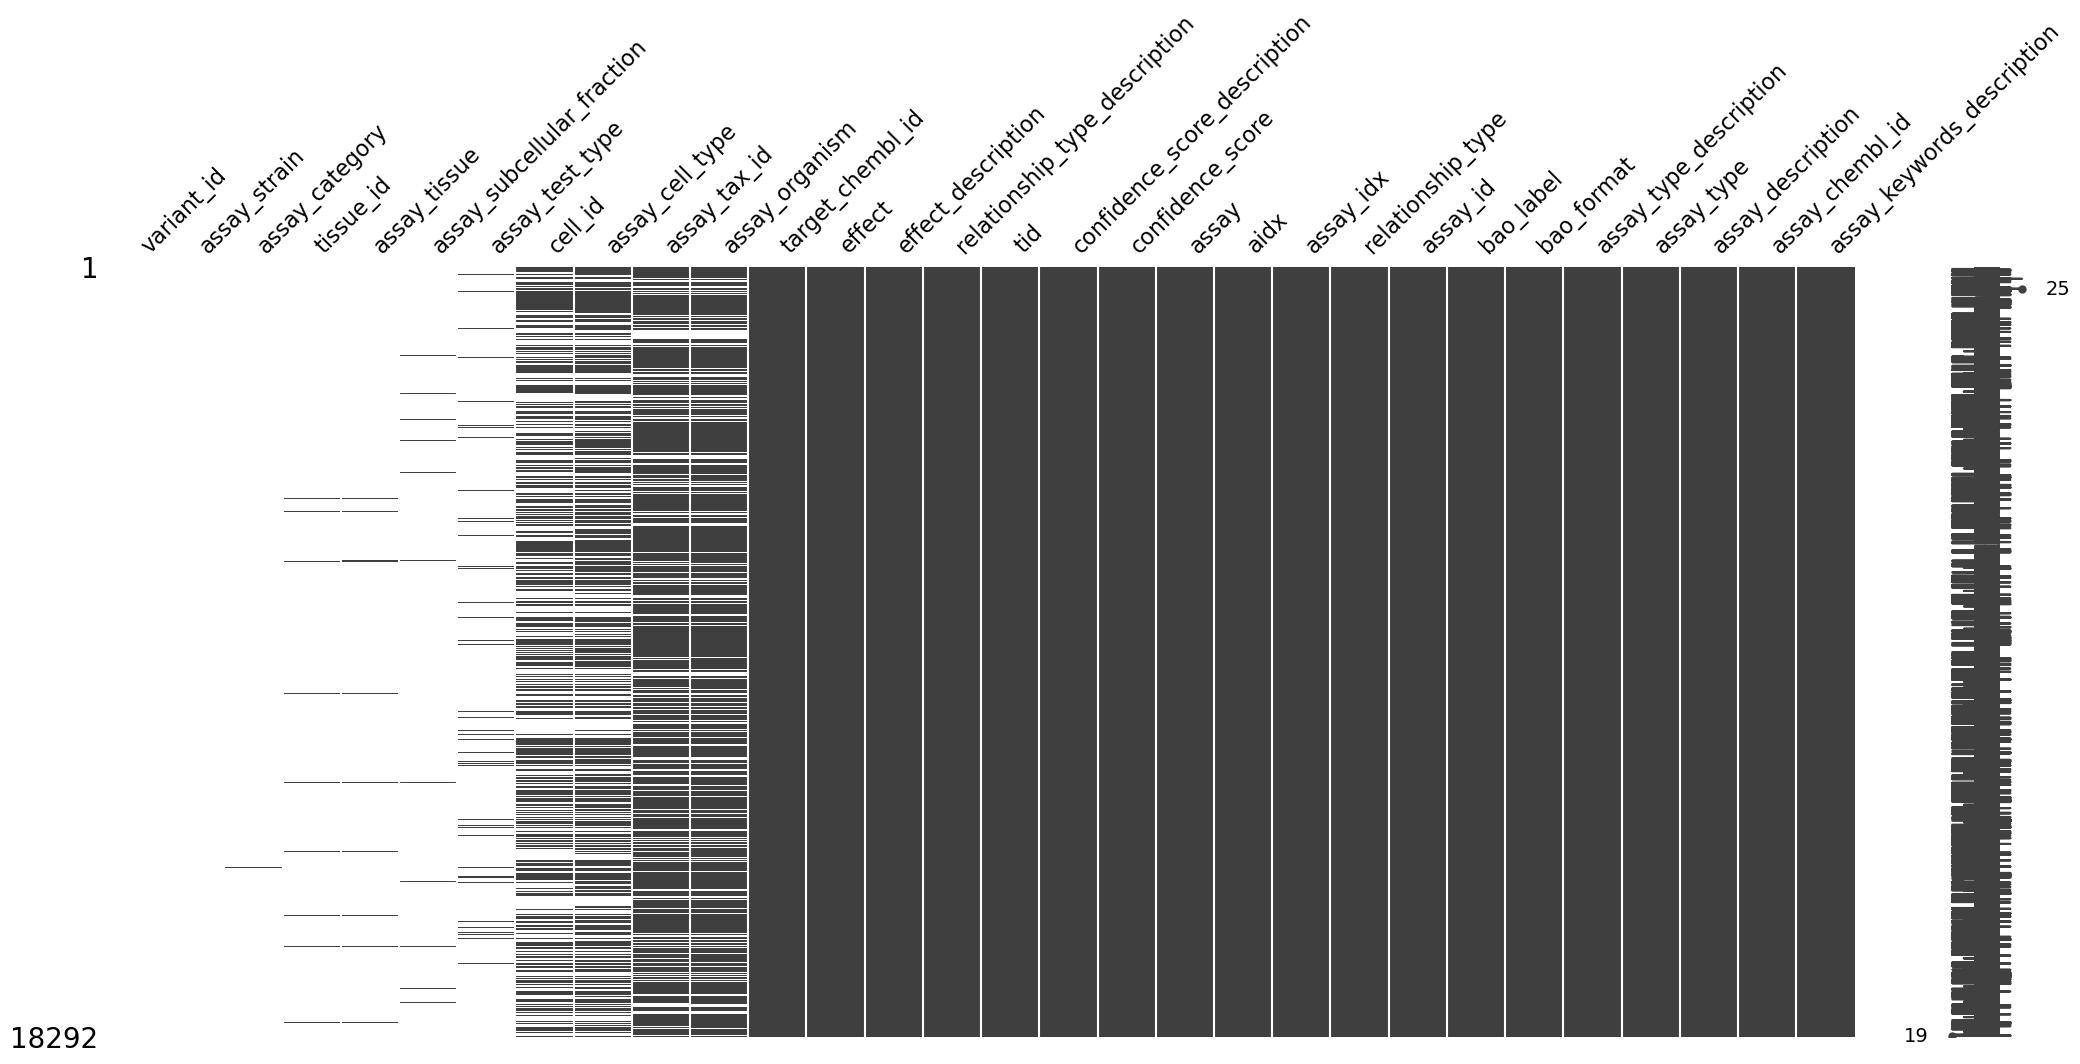

In [ ]:
# Matrix-style visualization
msno.matrix(assay_info_df)